# 3. Model Inference (PKL) - Glute Bridge
**Objective:**
1. Load a specific trained model pipeline (e.g., `RF_model.pkl`) from the `.pkl` file.
2. Load the raw test dataset.
3. Process the test data using the same feature extraction logic from the training notebook.
4. Perform inference on the preprocessed test data using the loaded pipeline.
5. Provide a detailed evaluation of the model's performance, including metrics and visualizations like a confusion matrix, ROC curve, and Precision-Recall curve.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
import matplotlib.pyplot as plt
import seaborn as sns

# Add root project directory to sys.path
module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from utils.geometry_utils import GeometryUtils
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['font.size'] = 10

## 3.1 Define Paths and Constants

In [2]:
BASE_DATA_PATH = "../data/"
TEST_RAW_PATH = os.path.join(BASE_DATA_PATH, "test.csv")

# >>>>> YOU CAN CHANGE THIS VALUE TO 'LR', 'KNN', 'DT', 'RF', or 'XGB' if you saved it earlier <<<<<
MODEL_PKL_DIR = "../models/pkl/"
MODEL_TYPE_TO_LOAD = "RF"
MODEL_PATH = os.path.join(MODEL_PKL_DIR, f"{MODEL_TYPE_TO_LOAD}_model.pkl")

print(f"Attempting to load model: {MODEL_PATH}")

Attempting to load model: ../models/pkl/RF_model.pkl


## 3.2 Feature Extraction (Same as Training Notebook)

In [3]:
# Re-defining constants and the feature extractor class for a self-contained notebook
VISIBILITY_THRESHOLD = 0.5
LANDMARK_NAMES = [
    'nose', 'left_eye_inner', 'left_eye', 'left_eye_outer', 'right_eye_inner', 'right_eye', 'right_eye_outer',
    'left_ear', 'right_ear', 'mouth_left', 'mouth_right', 'left_shoulder', 'right_shoulder', 'left_elbow',
    'right_elbow', 'left_wrist', 'right_wrist', 'left_pinky', 'right_pinky', 'left_index', 'right_index',
    'left_thumb', 'right_thumb', 'left_hip', 'right_hip', 'left_knee', 'right_knee', 'left_ankle',
    'right_ankle', 'left_heel', 'right_heel', 'left_foot_index', 'right_foot_index'
]
FEATURE_COLUMN_NAMES = [
    'left_elbow_angle', 'right_elbow_angle', 'left_shoulder_angle', 'right_shoulder_angle', 
    'left_hip_angle', 'right_hip_angle', 'left_knee_angle', 'right_knee_angle', 
    'left_body_align_angle', 'right_body_align_angle', 'left_hip_deviation', 'right_hip_deviation', 
    'shoulder_hip_y_diff_left', 'shoulder_hip_y_diff_right', 'hip_ankle_y_diff_left', 'hip_ankle_y_diff_right',
    'torso_length_left', 'torso_length_right', 'leg_length_left', 'leg_length_right'
]

class GluteBridgeFeatureExtractor:
    def __init__(self, geometry_util, visibility_threshold=0.5):
        self.geo = geometry_util
        self.visibility_threshold = visibility_threshold

    def _extract_single_frame_features(self, landmarks_dict):
        def get_coord(name): return landmarks_dict.get(name, [np.nan, np.nan])
        features = [
            self.geo.calculate_angle(get_coord('left_shoulder'), get_coord('left_elbow'), get_coord('left_wrist')),
            self.geo.calculate_angle(get_coord('right_shoulder'), get_coord('right_elbow'), get_coord('right_wrist')),
            self.geo.calculate_angle(get_coord('left_elbow'), get_coord('left_shoulder'), get_coord('left_hip')),
            self.geo.calculate_angle(get_coord('right_elbow'), get_coord('right_shoulder'), get_coord('right_hip')),
            self.geo.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_knee')),
            self.geo.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_knee')),
            self.geo.calculate_angle(get_coord('left_hip'), get_coord('left_knee'), get_coord('left_ankle')),
            self.geo.calculate_angle(get_coord('right_hip'), get_coord('right_knee'), get_coord('right_ankle')),
            self.geo.calculate_angle(get_coord('left_shoulder'), get_coord('left_hip'), get_coord('left_ankle')),
            self.geo.calculate_angle(get_coord('right_shoulder'), get_coord('right_hip'), get_coord('right_ankle')),
            self.geo.distance_point_to_line(get_coord('left_hip'), get_coord('left_shoulder'), get_coord('left_knee')),
            self.geo.distance_point_to_line(get_coord('right_hip'), get_coord('right_shoulder'), get_coord('right_knee')),
            abs(get_coord('left_shoulder')[1] - get_coord('left_hip')[1]),
            abs(get_coord('right_shoulder')[1] - get_coord('right_hip')[1]),
            abs(get_coord('left_hip')[1] - get_coord('left_ankle')[1]),
            abs(get_coord('right_hip')[1] - get_coord('right_ankle')[1]),
            self.geo.calculate_distance(get_coord('left_shoulder'), get_coord('left_hip')),
            self.geo.calculate_distance(get_coord('right_shoulder'), get_coord('right_hip')),
            self.geo.calculate_distance(get_coord('left_hip'), get_coord('left_ankle')),
            self.geo.calculate_distance(get_coord('right_hip'), get_coord('right_ankle'))
        ]
        return features

    def process_dataframe(self, df_raw):
        all_features, labels = [], []
        for index, row in df_raw.iterrows():
            landmarks = {}
            for name in LANDMARK_NAMES:
                x, y = row.get(f'{name}_x', np.nan), row.get(f'{name}_y', np.nan)
                visibility = row.get(f'{name}_v', 1.0 if not (np.isnan(x) or np.isnan(y)) else 0.0)
                landmarks[name] = [x, y] if visibility > self.visibility_threshold else [np.nan, np.nan]
            all_features.append(self._extract_single_frame_features(landmarks))
            labels.append(row['label'])
        
        X = pd.DataFrame(all_features, columns=FEATURE_COLUMN_NAMES)
        y = pd.Series(labels, name='label')

        if X.isnull().values.any():
             X.fillna(X.median(), inplace=True)
        
        label_map = {"glute_bridge_down": 0, "glute_bridge_up": 1}
        y_encoded = y.map(label_map)
        return X, y_encoded

## 3.3 Load Model and Test Data

In [4]:
model_pipeline = None
X_test, y_true = pd.DataFrame(), pd.Series(dtype='int')

try:
    with open(MODEL_PATH, "rb") as f:
        model_pipeline = pickle.load(f)
    print(f"Model pipeline loaded successfully from {MODEL_PATH}")
    print(f"Pipeline steps: {model_pipeline.steps}")

    # Load and process test data
    df_raw_test = pd.read_csv(TEST_RAW_PATH)
    geo_utils = GeometryUtils()
    feature_extractor = GluteBridgeFeatureExtractor(geo_utils, visibility_threshold=VISIBILITY_THRESHOLD)
    X_test, y_true = feature_extractor.process_dataframe(df_raw_test)
    print(f"Test data loaded and processed. Shape: X_test={X_test.shape}, y_true={y_true.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}. Check the path to your model or test data CSV.")
except Exception as e:
    print(f"An unexpected error occurred: {e}")

Model pipeline loaded successfully from ../models/pkl/RF_model.pkl
Pipeline steps: [('imputer', SimpleImputer(strategy='median')), ('scaler', StandardScaler()), ('model', RandomForestClassifier(class_weight='balanced', random_state=42))]
Test data loaded and processed. Shape: X_test=(29, 20), y_true=(29,)


## 3.4 Perform Inference and Evaluate


--- Performance Evaluation for RF Model ---

Classification Report:
              precision    recall  f1-score   support

    Down (0)       1.00      1.00      1.00        15
      Up (1)       1.00      1.00      1.00        14

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



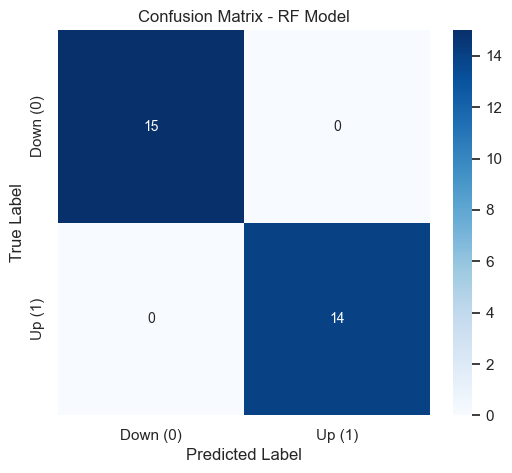

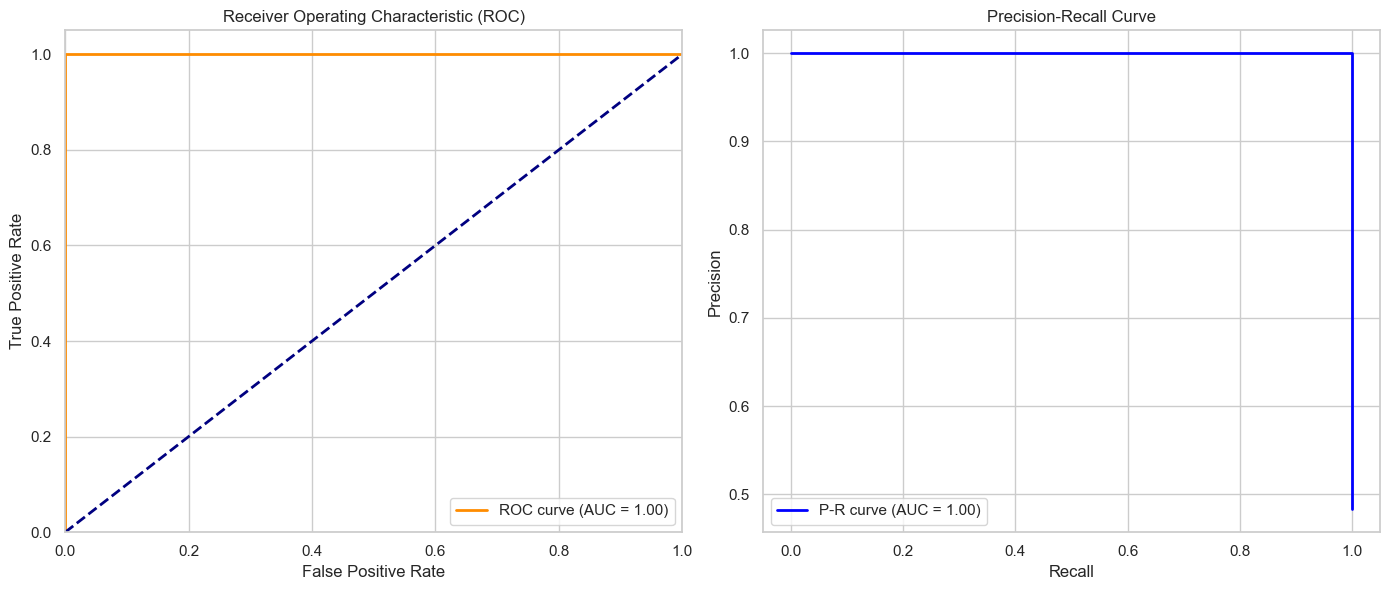

In [5]:
if model_pipeline and not X_test.empty:
    # Predict classes and probabilities
    y_pred = model_pipeline.predict(X_test)
    
    # Check if the final estimator in the pipeline supports predict_proba
    if hasattr(model_pipeline.steps[-1][1], 'predict_proba'):
        y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1] # Probability of the positive class (1: 'up')
    else:
        y_pred_proba = None
        print("The loaded model does not support predict_proba. ROC and P-R curves will not be generated.")

    # --- Evaluation --- #
    print(f"\n--- Performance Evaluation for {MODEL_TYPE_TO_LOAD} Model ---")
    
    # 1. Classification Report
    print("\nClassification Report:")
    target_names = ['Down (0)', 'Up (1)']
    print(classification_report(y_true, y_pred, target_names=target_names, zero_division=0))

    # 2. Confusion Matrix
    cm = confusion_matrix(y_true, y_pred, labels=[0, 1])
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(f'Confusion Matrix - {MODEL_TYPE_TO_LOAD} Model')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # 3. ROC and Precision-Recall Curves (if probabilities are available)
    if y_pred_proba is not None:
        fig, axes = plt.subplots(1, 2, figsize=(14, 6))
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        axes[0].plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
        axes[0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axes[0].set_xlim([0.0, 1.0])
        axes[0].set_ylim([0.0, 1.05])
        axes[0].set_xlabel('False Positive Rate')
        axes[0].set_ylabel('True Positive Rate')
        axes[0].set_title('Receiver Operating Characteristic (ROC)')
        axes[0].legend(loc="lower right")
        
        # Precision-Recall Curve
        precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
        pr_auc = auc(recall, precision)
        axes[1].plot(recall, precision, color='blue', lw=2, label=f'P-R curve (AUC = {pr_auc:.2f})')
        axes[1].set_xlabel('Recall')
        axes[1].set_ylabel('Precision')
        axes[1].set_title('Precision-Recall Curve')
        axes[1].legend(loc="lower left")
        
        plt.tight_layout()
        plt.show()
else:
    print("Could not perform inference. Model or test data is not loaded.")